In [41]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [2]:
# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-17 21:10:45--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  30.9MB/s    in 26s     

2020-05-17 21:11:12 (29.8 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



In [0]:
# Useful libraries
import numpy as np
import math as ma
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

In [0]:
#
# Parameters
#
Nsample = 100
Ninput = 10
Noutput = 5
loss = 'binary_crossentropy'
#loss = tfa.losses.SigmoidFocalCrossEntropy()

In [45]:
#
# Data processing
#
data = np.load('mnist_test_seq.npy')
data = data.swapaxes(0, 1) # swap frames and instances for tf handling
data = data[:Nsample, :, :, :] # reduce memory and compute requirements by selecting a subsample
data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
data = data/np.amax(data) # minmax normalize data
data = tf.cast(data, tf.float32) # convert to float32 for tf handling
N, F, H, W, C = data.shape # save dims
print('(instance, frame, height, width, channel) = '+str(data.shape))
print('min value = '+str(np.amin(data)))
print('max value = '+str(np.amax(data)))

(instance, frame, height, width, channel) = (100, 20, 64, 64, 1)
min value = 0.0
max value = 1.0


In [46]:
def make_train_data(data, Ninput):
  X = data[:, :Ninput, :, :, :]
  y = data[:, Ninput:Ninput+Noutput, :, :, :]
  return X, y
X, y = make_train_data(data, Ninput)
print("X is:", X.shape)
print("y is:", y.shape)

X is: (100, 10, 64, 64, 1)
y is: (100, 5, 64, 64, 1)


In [0]:
# Our Model Architecture
def model_init(Nout): 
    inputs = tf.keras.Input(shape=[None, H, W, C])
    # Encoder
    CL1, cl1_h, cl1_c = tf.keras.layers.ConvLSTM2D(128, 5, padding='same', 
                                                   return_sequences=True, return_state=True)(inputs)
    CL2, cl2_h, cl2_c = tf.keras.layers.ConvLSTM2D(128, 5, padding='same', 
                                                   return_state=True)(CL1)
    # Repeat outputs
    CL2 = tf.keras.layers.Reshape([H*W*128])(CL2)
    CL2 = tf.keras.layers.RepeatVector(Nout)(CL2)
    CL2 = tf.keras.layers.Reshape([Noutput, H, W, 128])(CL2)
    # Decoder
    CL3 = tf.keras.layers.ConvLSTM2D(128, 5, padding='same',
                                     return_sequences=True,)(CL2, initial_state=[cl1_h, cl1_c])
    CL4 = tf.keras.layers.ConvLSTM2D(128, 5, padding='same',
                                     return_sequences=True,)(CL3, initial_state=[cl2_h, cl2_c])
    # Prediction
    concat = tf.keras.layers.Concatenate()([CL3, CL4])
    preds = tf.keras.layers.Conv3D(1, 1, padding='same', 
                                   bias_initializer=tf.keras.initializers.Constant(value=-np.log(99)),
                                   activation='sigmoid')(concat)
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Learning rate step decay
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * ma.pow(drop, ma.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [0]:
# Custom metrics
def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [50]:
# Initialize model
model = model_init(Noutput)
# Build optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss,
              metrics=['acc', 'mse', 'binary_crossentropy', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.FalseNegatives(name='FN'), 
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.TrueNegatives(name='TN'), 
                       tf.keras.metrics.TruePositives(name='TP')])
# Fit the model
#callbacks_list = [lrate]
history = model.fit(X, y, 
                    batch_size=5, epochs=20, 
                    #callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/20
18/18 [==============================] - 45s 2s/step - loss: 0.3261 - acc: 0.8865 - mse: 0.0746 - binary_crossentropy: 0.3261 - ssim: 0.1427 - psnr: 13.3133 - cor: 0.0991 - prec: 0.0707 - recall: 0.0445 - FN: 126342.0000 - FP: 77315.0000 - TN: 1633664.0000 - TP: 5879.0000 - val_loss: 0.1900 - val_acc: 0.9267 - val_mse: 0.0405 - val_binary_crossentropy: 0.1900 - val_ssim: 0.0373 - val_psnr: 13.9699 - val_cor: 0.1789 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00 - val_FN: 15022.0000 - val_FP: 0.0000e+00 - val_TN: 189778.0000 - val_TP: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 42s 2s/step - loss: 0.1901 - acc: 0.9283 - mse: 0.0399 - binary_crossentropy: 0.1901 - ssim: 0.0506 - psnr: 14.1039 - cor: 0.1495 - prec: 0.0000e+00 - recall: 0.0000e+00 - FN: 132221.0000 - FP: 0.0000e+00 - TN: 1710979.0000 - TP: 0.0000e+00 - val_loss: 0.1995 - val_acc: 0.9267 - val_mse: 0.0415 - val_binary_crossentropy: 0.1995 - val_ssim: 0.0161 - val_psnr: 13.8599 - val_cor: 0.167

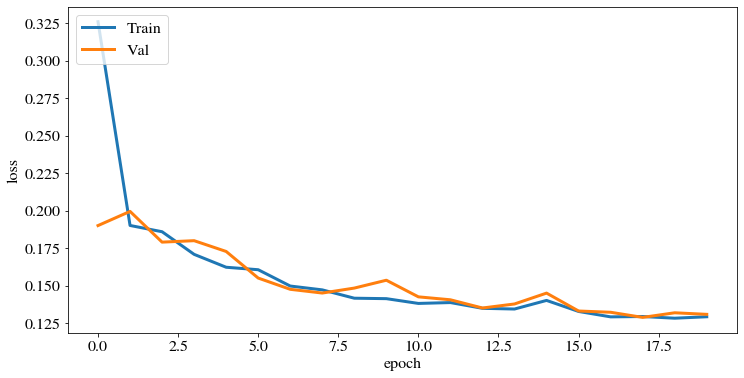

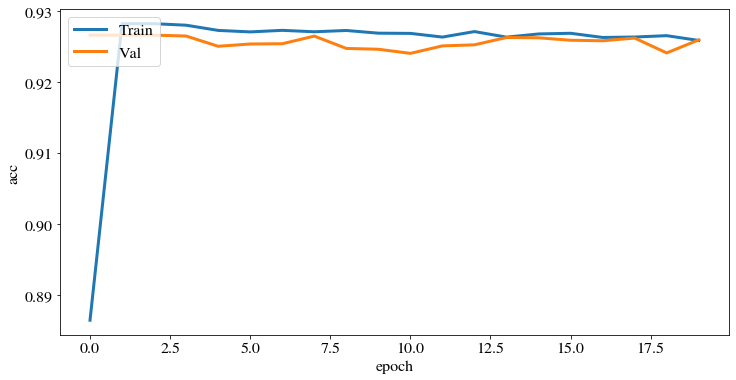

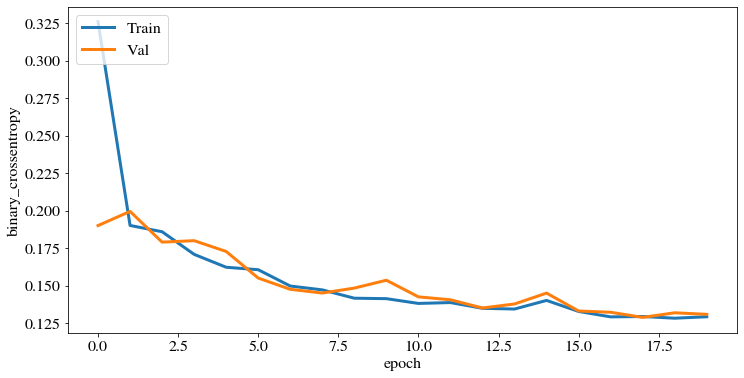

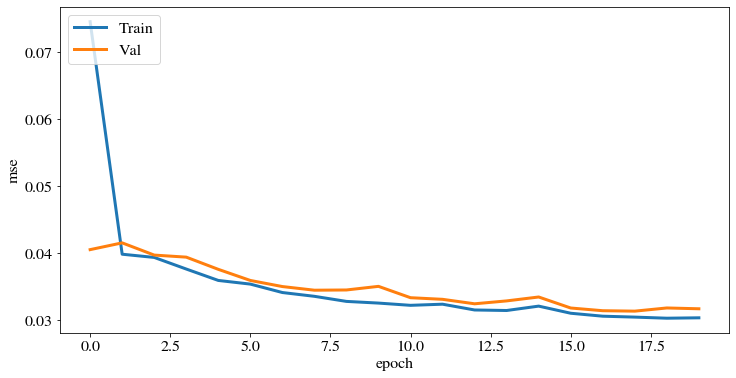

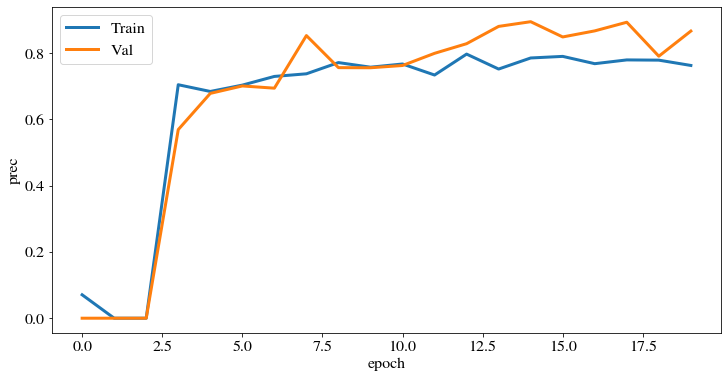

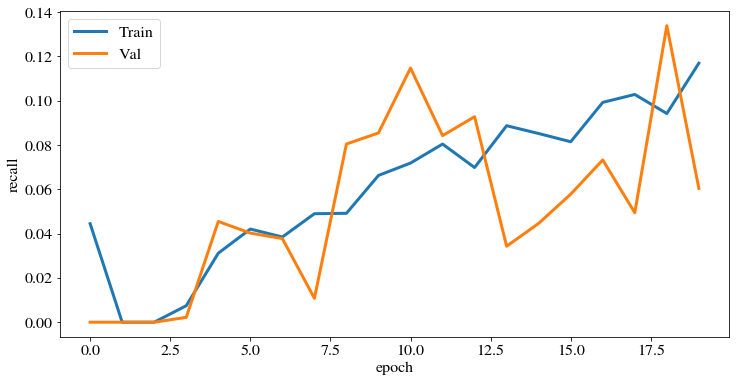

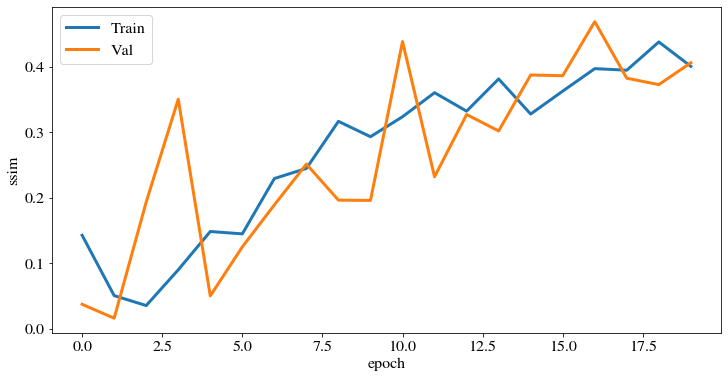

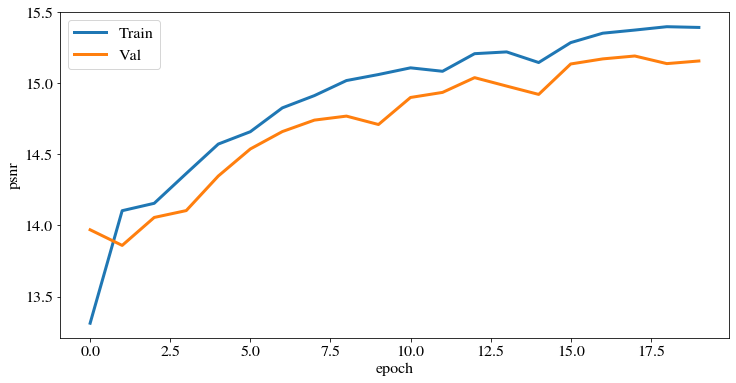

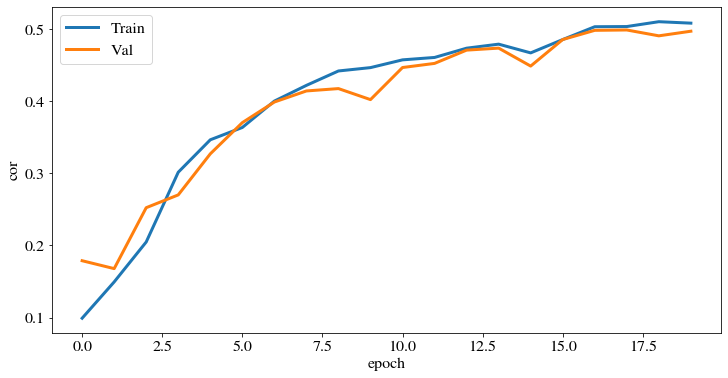

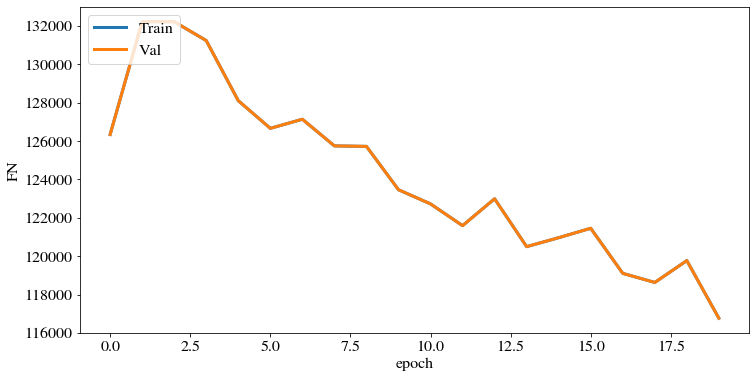

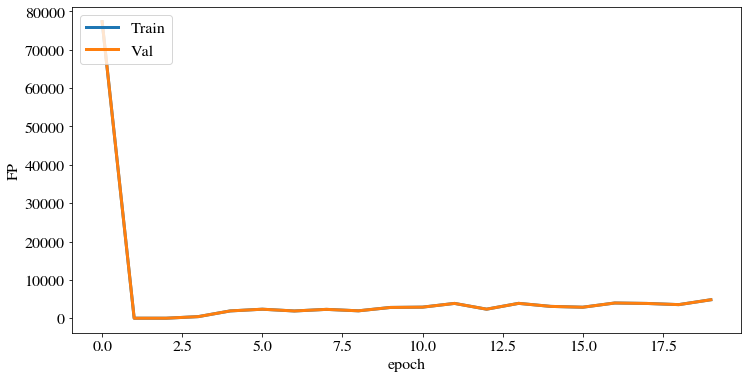

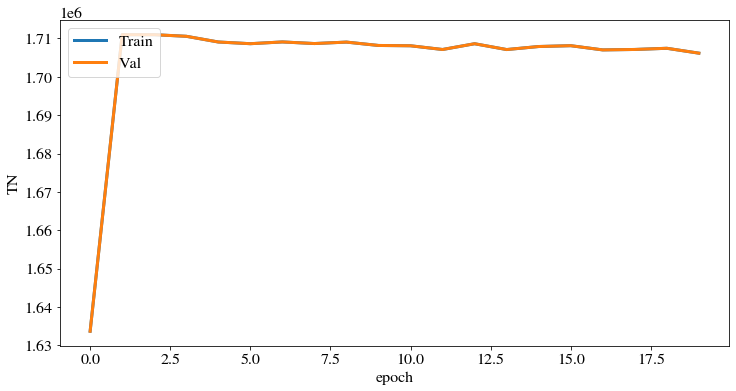

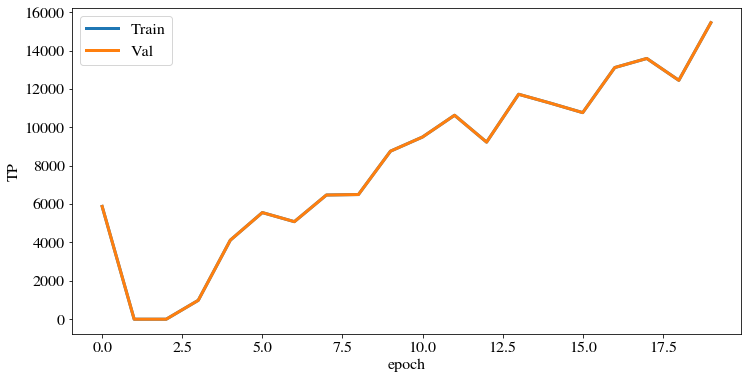

In [51]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_crossentropy'], label='Train')
plt.plot(history.history['val_binary_crossentropy'], label='Val')
plt.ylabel('binary_crossentropy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('binary_crossentropy.png')
files.download('binary_crossentropy.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['mse'], label='Train')
plt.plot(history.history['val_mse'], label='Val')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('mse.png')
files.download('mse.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
files.download('psnr.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FN'], label='Train')
plt.plot(history.history['FN'], label='Val')
plt.ylabel('FN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FN.png')
files.download('FN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FP'], label='Train')
plt.plot(history.history['FP'], label='Val')
plt.ylabel('FP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FP.png')
files.download('FP.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TN'], label='Train')
plt.plot(history.history['TN'], label='Val')
plt.ylabel('TN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TN.png')
files.download('TN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TP'], label='Train')
plt.plot(history.history['TP'], label='Val')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TP.png')
files.download('TP.png')

In [52]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 1
track = X[itest, :, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict(track[None,:,:,:,:])), axis=1)
print("track:", track.shape)

track: (1, 15, 64, 64, 1)


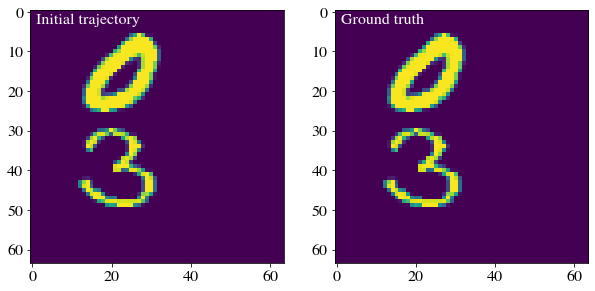

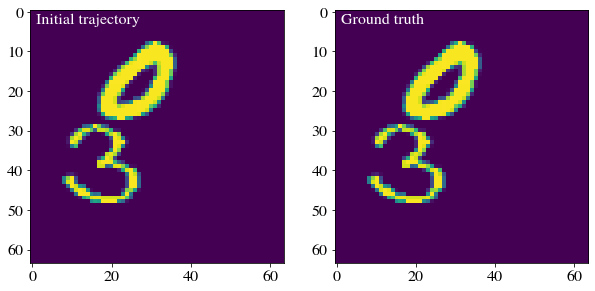

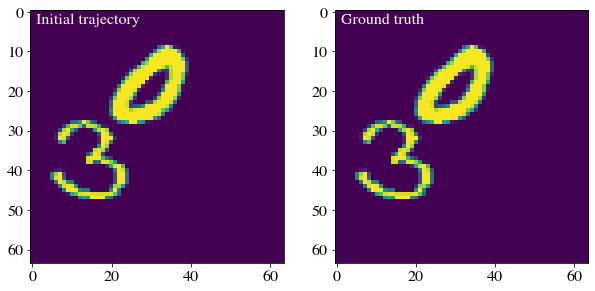

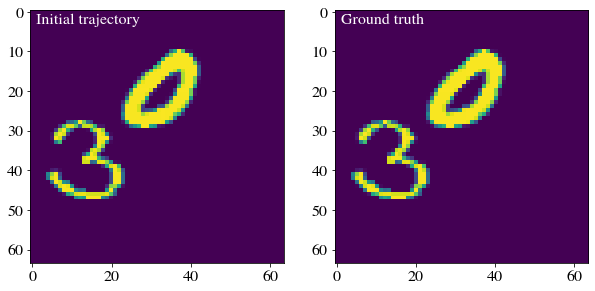

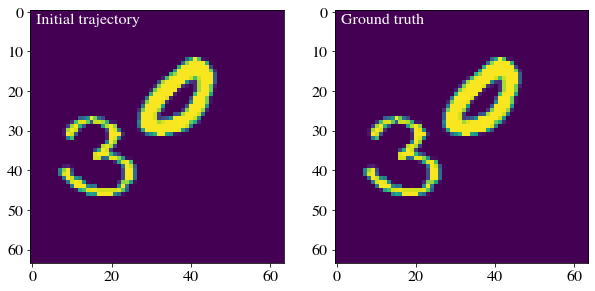

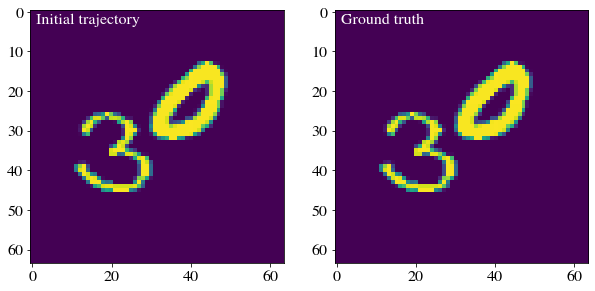

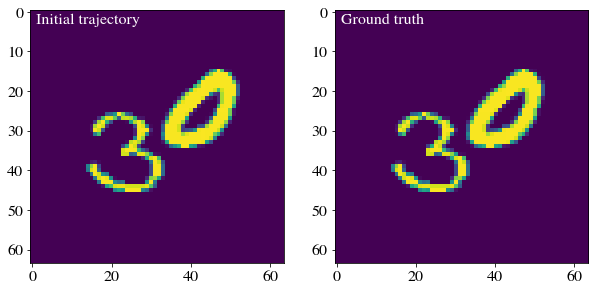

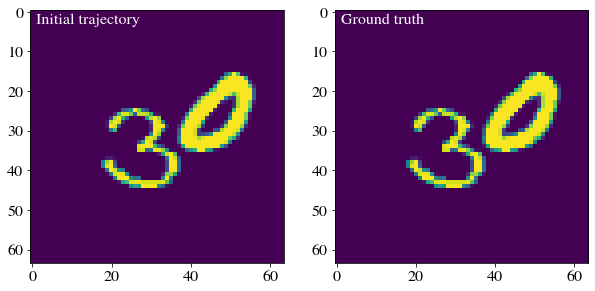

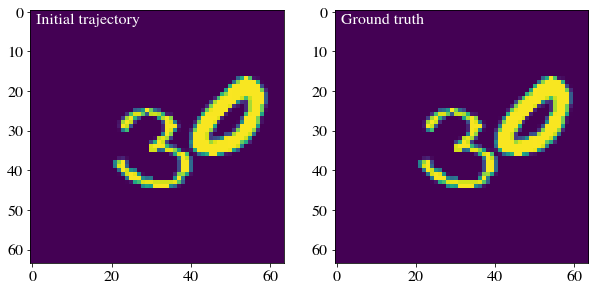

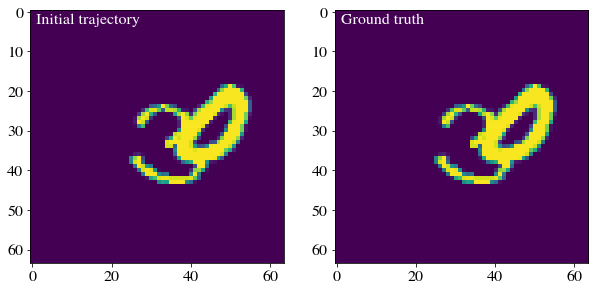

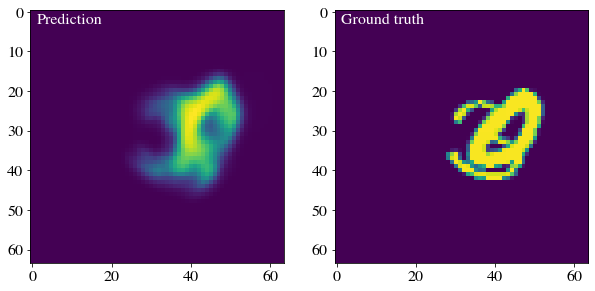

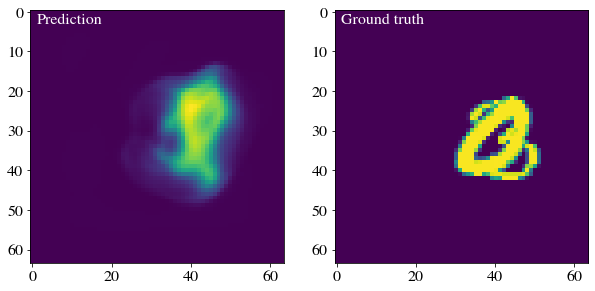

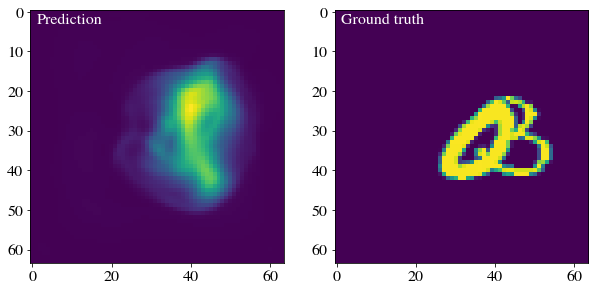

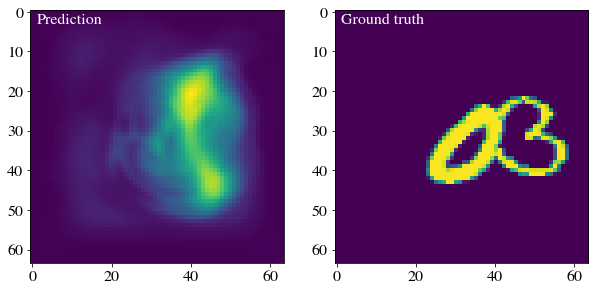

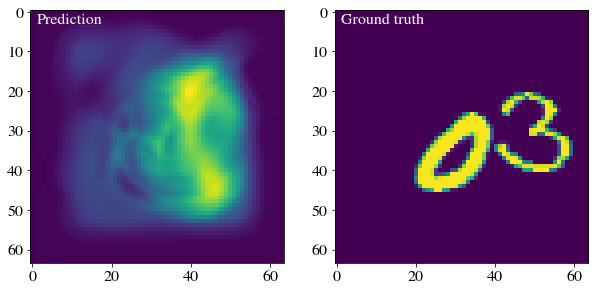

In [53]:
# Plot results
true_track = data[itest, :, :, :, :]

for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])

    plt.savefig('anim_%i.png' % (i+1))
    #files.download('anim_%i.png' % (i+1))